In [119]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from support_functions import (atipicosAmissing, graficoVcramer, create_target_variable_boxplots)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from joblib import dump, load

seed = 42

Obtenemos la carpeta actual:

In [36]:
current_dir = Path.cwd()
DATASETS_LOCATION = os.path.join(current_dir.parent.parent.parent, 'datasets')
MODELS_LOCATION = os.path.join(current_dir.parent.parent, 'models')

Cargamos el dataset en un dataframe, y definimos nuestra variable target:

In [37]:
df_disease = pd.read_csv(os.path.join(DATASETS_LOCATION, 'blood_samples_dataset.csv'))
var_target = "Disease"

# Análisis exploratorio de los datos

Empecemos comprobando el formato de cada una de nuestras variables:

In [38]:
df_disease.dtypes

Glucose                                      float64
Cholesterol                                  float64
Hemoglobin                                   float64
Platelets                                    float64
White Blood Cells                            float64
Red Blood Cells                              float64
Hematocrit                                   float64
Mean Corpuscular Volume                      float64
Mean Corpuscular Hemoglobin                  float64
Mean Corpuscular Hemoglobin Concentration    float64
Insulin                                      float64
BMI                                          float64
Systolic Blood Pressure                      float64
Diastolic Blood Pressure                     float64
Triglycerides                                float64
HbA1c                                        float64
LDL Cholesterol                              float64
HDL Cholesterol                              float64
ALT                                          f

Observamos que todas tienen el tipo de datos que queremos. Veamos ahora si hay valores perdidos.

## Valores perdidos

Comprobemos si hay valores perdidos en las variables:

In [39]:
print(f"Hay {df_disease.isna().sum().sum()} valores perdidos")

hay 0 valores perdidos


## Valores erróneos

Veamos ahora si hay valores erróneos:

In [40]:
descriptivos_max_min = round(df_disease.describe().T[['max', 'min']],2)
descriptivos_max_min

,max,min
Glucose,0.99,0.00
Cholesterol,1.00,0.00
Hemoglobin,1.00,0.00
Platelets,1.00,0.00
White Blood Cells,1.00,-0.00
Red Blood Cells,1.00,0.00
Hematocrit,1.00,0.00
Mean Corpuscular Volume,1.00,0.00
Mean Corpuscular Hemoglobin,1.00,-0.00
Mean Corpuscular Hemoglobin Concentration,1.00,0.00


Observamos que todos los valores están correctamente entre 0 y 1. Pasemos ahora a ver si hay datos atípicos.


## Datos atípicos

Se tiene que la proporción de valores atípicos se calcula dividiendo la cantidad de valroes atípicos por el número total de filas:

In [41]:
numericas_input = df_disease.select_dtypes(include = ['int', 'int32', 'int64','float', 'float32', 'float64']).columns
resultados = {x: atipicosAmissing(df_disease[x])[1] / len(df_disease) for x in numericas_input}
resultados = {key: value for key, value in resultados.items() if value!= 0} # Elimino la variable si no tiene valores atípicos
if resultados:
    for key, value in resultados.items():
        print(f'{key}: {round(value*100,2)}% de valores atípicos en la variable')
else:
    print("No hay datos atípicos")

No hay datos atipicos


Veamos cómo está distribuida nuestra variable target.

## Distibucion variable target

In [42]:
df_disease[var_target].value_counts()

Disease
Diabetes    834
Anemia      707
Healthy     561
Thalasse    557
Thromboc    139
Heart Di     39
Name: count, dtype: int64

Procedemos a renombrar algunas de las clases de la variable target, para su mejor comprensión. Además, también vamos a quitar una de las clases, "heart di", ya que no la vamos a utilizar:

In [43]:
df_disease[var_target] = df_disease[var_target].replace({
    'Thalasse': 'Thalassemia',
    'Thromboc': 'Thrombosis'
})

df_disease = df_disease[df_disease[var_target] != 'Heart Di']

# Veamos que nuestros cambios se han realizado correctamente
print(df_disease[var_target].value_counts())

Disease
Diabetes       834
Anemia         707
Healthy        561
Thalassemia    557
Thrombosis     139
Name: count, dtype: int64


Observamos que ya está todo tal y como queremos. Pasemos a ver la correlación entre variables.

## Correlación entre variables

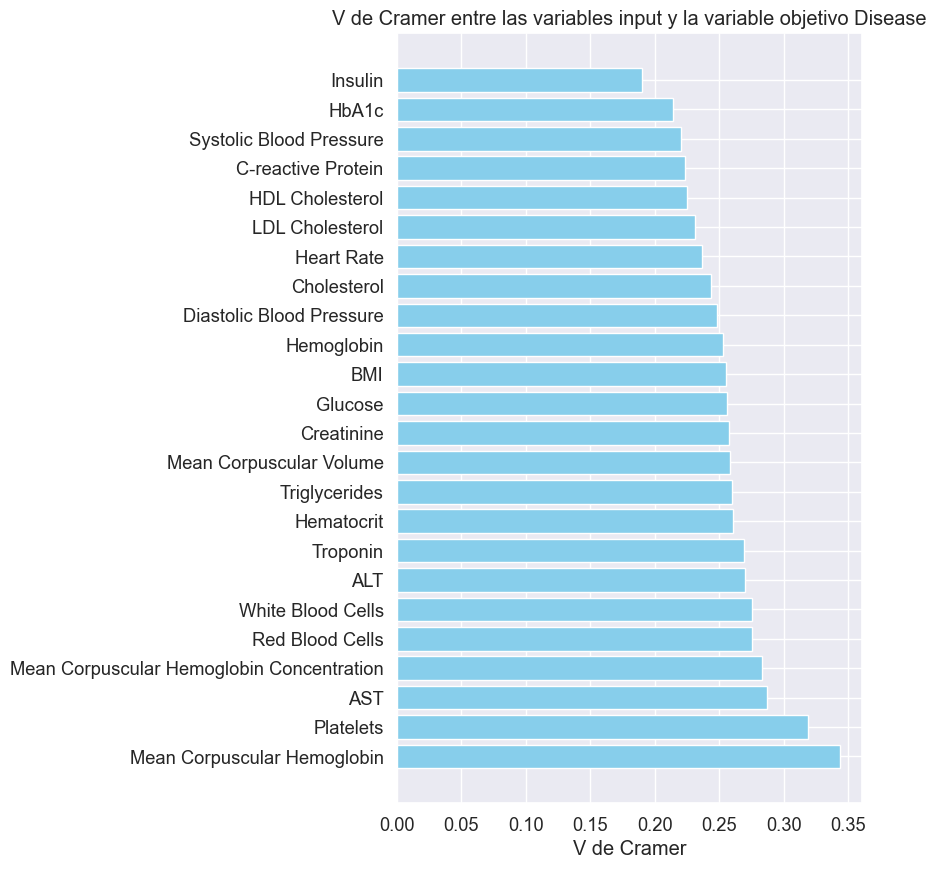

{'Mean Corpuscular Hemoglobin': 0.3435722528967313,
 'Platelets': 0.3187702624531197,
 'AST': 0.28735863127411865,
 'Mean Corpuscular Hemoglobin Concentration': 0.28292157988652966,
 'Red Blood Cells': 0.2757430972696437,
 'White Blood Cells': 0.2755488463251754,
 'ALT': 0.27029673838408164,
 'Troponin': 0.26946401696525846,
 'Hematocrit': 0.2605545295361615,
 'Triglycerides': 0.25961671658786817,
 'Mean Corpuscular Volume': 0.25874336395395536,
 'Creatinine': 0.25784426592757037,
 'Glucose': 0.25640352378625964,
 'BMI': 0.25547676678459463,
 'Hemoglobin': 0.25316357228348,
 'Diastolic Blood Pressure': 0.24836291488530532,
 'Cholesterol': 0.24338911973816213,
 'Heart Rate': 0.23671738116169708,
 'LDL Cholesterol': 0.23103428924150282,
 'HDL Cholesterol': 0.22517992182149074,
 'C-reactive Protein': 0.2230886805522568,
 'Systolic Blood Pressure': 0.2202299294519316,
 'HbA1c': 0.21397251873059836,
 'Insulin': 0.19011220727152253}

In [44]:
graficoVcramer(df_disease.drop(columns=[var_target]), df_disease[var_target])

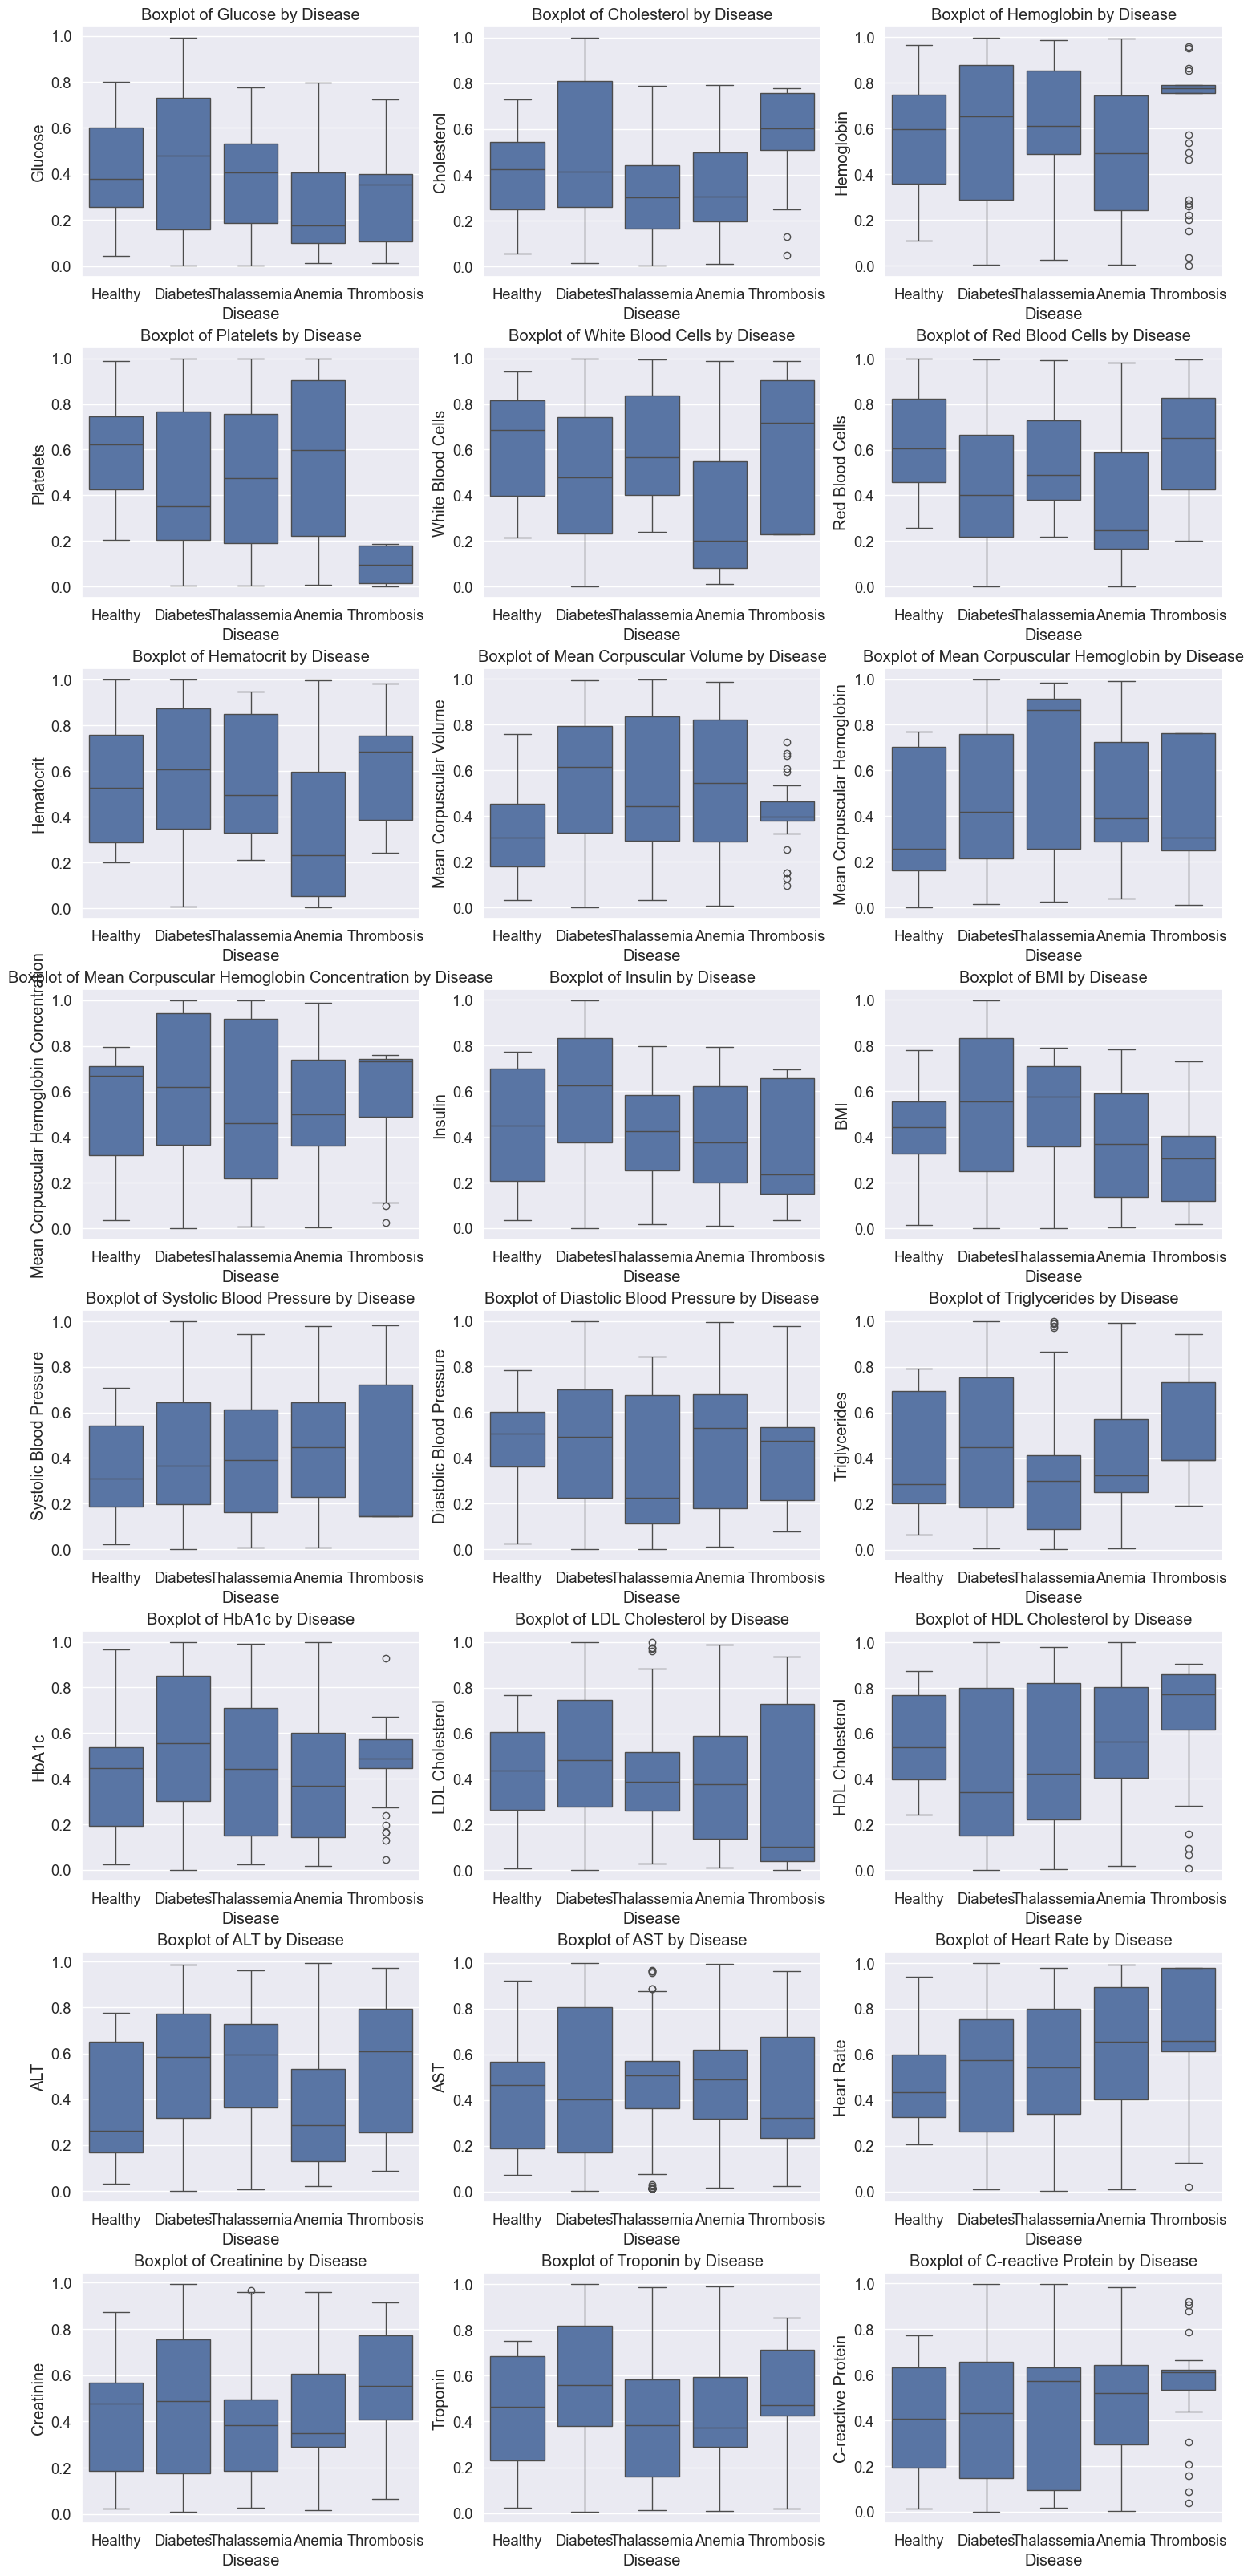

In [45]:
create_target_variable_boxplots(dataframe=df_disease,
                                target_col=var_target)

## Correlación entre todas las variables numéricas

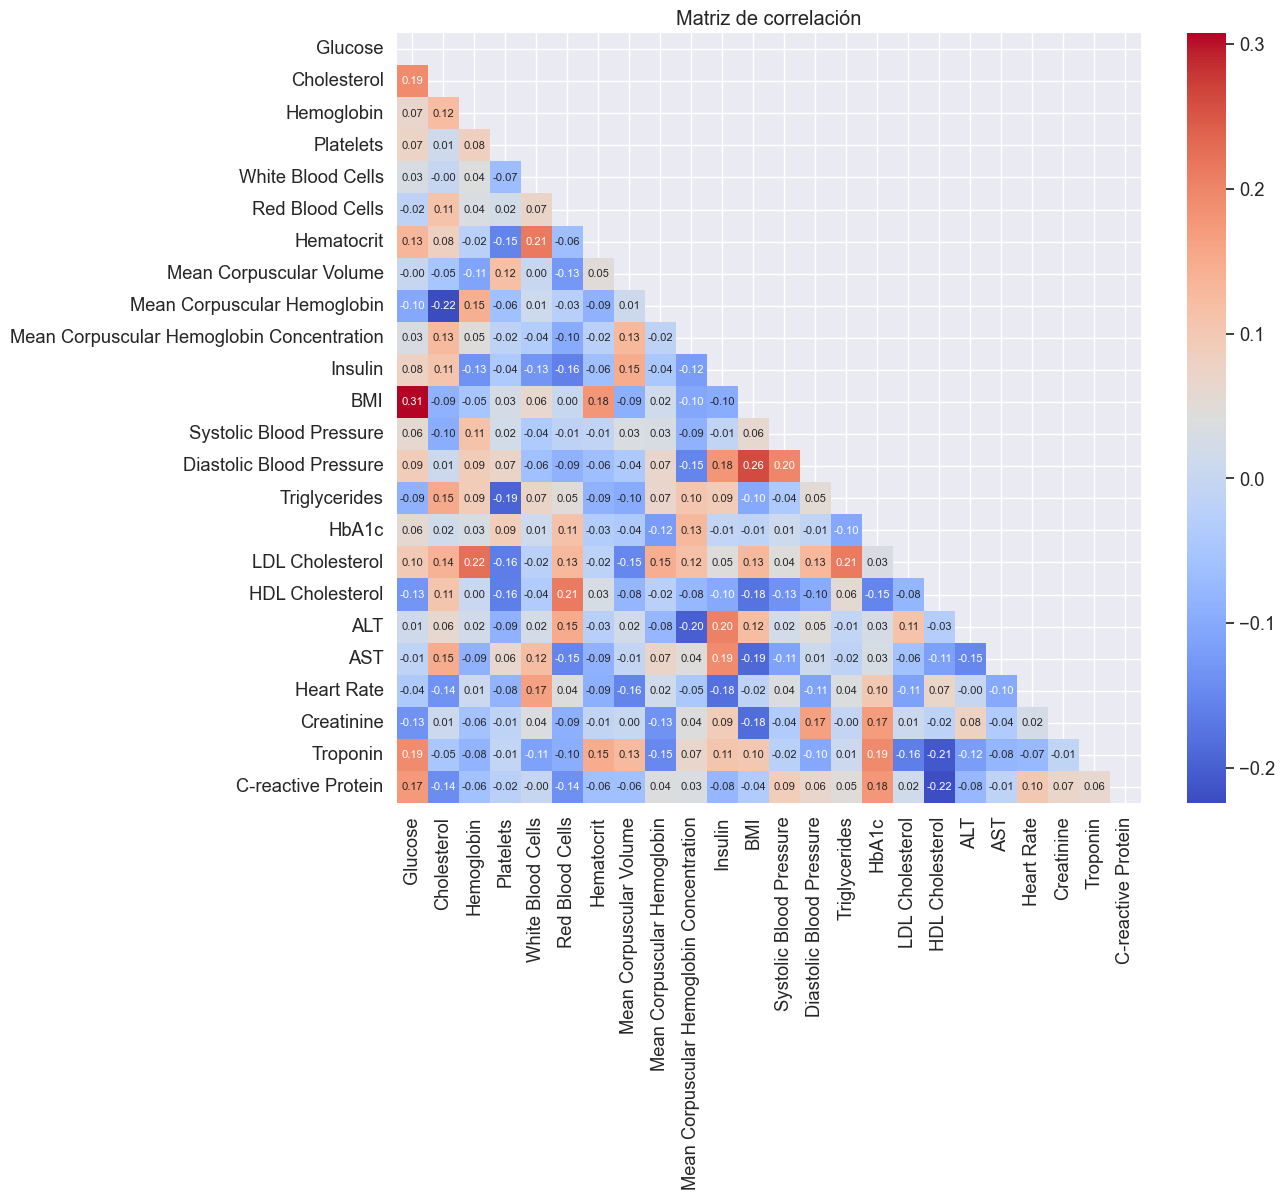

In [46]:
# Obtener las columnas numéricas del DataFrame 'datos_input'
numericas = df_disease.select_dtypes(include=['int', 'float']).columns
# Calcular la matriz de correlación de Pearson entre la variable objetivo continua ('varObjCont') y las variables numéricas
matriz_corr = df_disease[numericas].corr(method = 'pearson')
# Crear una máscara para ocultar la mitad superior de la matriz de correlación (triangular superior)
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))
# Crear una figura para el gráfico con un tamaño de 8x6 pulgadas
plt.figure(figsize=(12, 10))
# Establecer el tamaño de fuente en el gráfico
sns.set(font_scale=1.2)
# Crear un mapa de calor (heatmap) de la matriz de correlación
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, mask=mask, annot_kws={"size": 8})
# Establecer el título del gráfico
plt.title("Matriz de correlación")
# Mostrar el gráfico de la matriz de correlación
plt.show()

Non c'e' una correlazione evidente fra le varie variabili del dataset

# Train test split

In [47]:
X = df_disease.drop(columns=[var_target])  
y = df_disease[var_target]  # La variable objetivo

# Realizamos el train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# One-Hot Encoding para la variable target
encoder = OneHotEncoder(sparse_output=False)  
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Mostrar las nuevas categorías de la variable target
print(f"Categorías codificadas: {encoder.categories_} \n")
print(f"Tamaño del dataset de entrenamiento: {len(X_train)}")
print(f"Tamaño del dataset de prueba: {len(X_test)}")


Categorías codificadas: [array(['Anemia', 'Diabetes', 'Healthy', 'Thalassemia', 'Thrombosis'],
      dtype=object)] 

Tamaño del dataset de entrenamiento: 2238
Tamaño del dataset de prueba: 560


Siccome i valori hanno massimo 1 (solo in un caso 0.99) e minimo 0, normalizzare i dati sarebbe inutile.

# SVM

## Addestramento

In [48]:
# Definizione dei parametri per il GridSearch
svm_params = {
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto'],
}

# Pipeline per il modello SVM
svm_pipeline = Pipeline([
    ('svm', SVC(probability=True, random_state=seed, class_weight='balanced'))
])

# Grid Search per ottimizzare i parametri
svm_grid_search = GridSearchCV(
    svm_pipeline, svm_params, cv=3, scoring='accuracy', n_jobs=-1
)

print("Inizio la ricerca dei migliori parametri per SVM...")
svm_grid_search.fit(X_train, y_train)

# Miglior modello senza Bagging
best_svm = svm_grid_search.best_estimator_
print(f"Migliori parametri SVM senza Bagging: {svm_grid_search.best_params_}")

Inizio la ricerca dei migliori parametri per SVM...
Migliori parametri SVM senza Bagging: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


## Valutazione

In [49]:
# Valutazione del modello ottimizzato senza Bagging
y_pred_best_svm = best_svm.predict(X_test)
print("\nReport di classificazione per SVM ottimizzato:")
print(classification_report(y_test, y_pred_best_svm))


Report di classificazione per SVM ottimizzato:
              precision    recall  f1-score   support

      Anemia       0.97      0.97      0.97       150
    Diabetes       0.93      0.98      0.95       170
     Healthy       0.99      0.98      0.99       117
 Thalassemia       0.99      0.96      0.97        95
  Thrombosis       1.00      0.89      0.94        28

    accuracy                           0.97       560
   macro avg       0.98      0.96      0.97       560
weighted avg       0.97      0.97      0.97       560



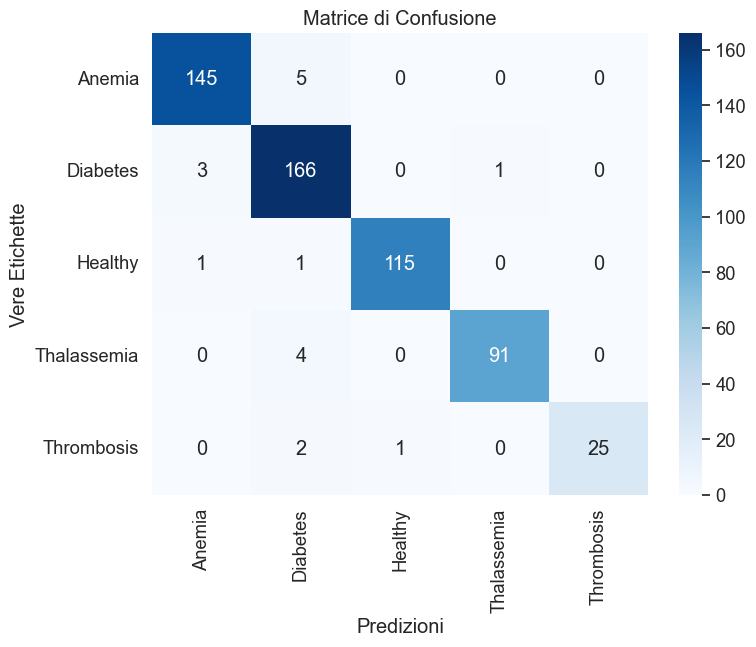

In [50]:
# Matrice di confusione
cm = confusion_matrix(y_test, y_pred_best_svm)
class_names = encoder.categories_[0]

# Visualizzare la matrice di confusione usando heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predizioni')
plt.ylabel('Vere Etichette')
plt.title('Matrice di Confusione')
plt.show()

In [51]:
#  valutiamo con validacion cruzada
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.95442359 0.95040214 0.95308311]
Accuracy media de la validación cruzada: 0.953
Desviación estándar de las diferentes accuracys de la CV: 0.002


## Conclusioni

Risultato molto buono, il kernel non lineare dell'svm unito al class:weight balanced permette di avere ottime performance nonostante il dataset sia piccolo e le classi non bilanciate

# KNN neighbours

## Preprocessing

I dati non hanno valori atipici o mancanti, inoltre sono gia' normalizzati. Non occorre quindi preprocessing

## Training

In [52]:
KNN=KNeighborsClassifier()

KNN.fit(X_train, y_train) ## entrenando
print('Accuracy del modelo en train: %.3f' %KNN.score(X_train, y_train), 
      'Accuracy del modelo en test: %.3f ' %KNN.score(X_test, y_test))

Accuracy del modelo en train: 0.927 Accuracy del modelo en test: 0.918 


### Bagging

In [53]:
# TODO VALORI FRA MAX E MIN
n_estimators_list = [50, 100, 200]
max_samples_list = [0.5, 0.7, 0.8]
max_features_list = [0.2, 0.3]
n_neighbors_list = [2, 3, 4]

results_knn = []

for n_estimators in n_estimators_list:
    print(f"processing {n_estimators} estimators")
    for max_samples in max_samples_list:
        print(f"processing {max_samples} max_samples")
        for max_features in max_features_list:
            for n_neighbors in n_neighbors_list:
                # Crea el clasificador Bagging con KNN
                bagging_model = BaggingClassifier(
                    KNeighborsClassifier(n_neighbors=n_neighbors),
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    max_features=max_features,
                    bootstrap_features=True,
                    random_state=seed
                )
                
                # Adiestra el clasificador Bagging
                bagging_model.fit(X_train, y_train)
                
                train_score = bagging_model.score(X_train, y_train)
                test_score = bagging_model.score(X_test, y_test)
                
                results_knn.append({
                    'n_estimators': int(n_estimators),
                    'max_samples': max_samples,
                    'max_features': max_features,
                    'n_neighbors': n_neighbors,
                    'train_score': train_score,
                    'test_score': test_score
                })

# Crea un DataFrame con los resultados
results_knn_df = pd.DataFrame(results_knn)

processing 50 estimators
processing 0.5 max_samples
processing 0.7 max_samples
processing 0.8 max_samples
processing 100 estimators
processing 0.5 max_samples
processing 0.7 max_samples
processing 0.8 max_samples
processing 200 estimators
processing 0.5 max_samples
processing 0.7 max_samples
processing 0.8 max_samples


## Evaluacion

In [54]:
results_knn_df = results_knn_df.sort_values('test_score', ascending=False).head()
results_knn_df.head(3)

,n_estimators,max_samples,max_features,n_neighbors,train_score,test_score
21,100,0.5,0.3,2,0.986595,0.957143
41,200,0.5,0.3,4,0.971403,0.957143
39,200,0.5,0.3,2,0.989723,0.957143


In [55]:
best_params_bag_knn = dict(results_knn_df.iloc[0][['n_estimators','max_samples','max_features']])
best_params_bag_knn['n_estimators'] = int(best_params_bag_knn['n_estimators'])
best_knn_neighb = int(results_knn_df.iloc[0][['n_neighbors']])
best_params_bag_knn, best_knn_neighb

C:\Users\maria\AppData\Local\Temp\ipykernel_10256\205366803.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_knn_neighb = int(results_knn_df.iloc[0][['n_neighbors']])


({'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.3}, 2)

Realicemos la validación cruzada y obtengamos los resultados:

In [56]:
best_model_bagging_knn = BaggingClassifier(
                                            KNeighborsClassifier(n_neighbors=best_knn_neighb),
                                            **best_params_bag_knn,
                                            bootstrap_features=True,
                                            random_state=seed
                                        )

cv_scores = cross_val_score(best_model_bagging_knn, X_train, y_train, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.95040214 0.94369973 0.94235925]
Accuracy media de la validación cruzada: 0.945
Desviación estándar de las diferentes accuracys de la CV: 0.004


Calculemos la accuracy en train y en test para el mejor modelo obtenido:

In [57]:
best_model_bagging_knn.fit(X_train, y_train)
best_y_pred_gab_knn_test = best_model_bagging_knn.predict(X_test)
best_y_pred_gab_knn_train = best_model_bagging_knn.predict(X_train)

print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,best_y_pred_gab_knn_train)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,best_y_pred_gab_knn_test)}')

Se tiene un accuracy para train de: 0.9865951742627346
Se tiene un accuracy para test de: 0.9571428571428572


## Conclusioni

Il modello KNN performa molto bene, considerando il basso numero di K-neighbours scelti. Fra i vari motivi, questo e' dovuto all'assenza di valori atipici nel dataset che permettono una clusterizzazione efficace.

# Decission Tree

## Training

### Modelo base

Empecemos construyendo el primer modelo de árbol de decisión, con todas las variables y con profundidad máxima 4:

In [82]:
arbol1 = DecisionTreeClassifier(min_samples_split=30, criterion='gini', max_depth = 5)
arbol1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=30)

Calculamos las predicciones en test, y visualizamos la matriz de confusión:

In [83]:
y_train_pred = arbol1.predict(X_train)
y_test_pred = arbol1.predict(X_test)
print("\nclassification_report train:")
print(classification_report(y_train, y_train_pred))
print("\nclassification_report test:")
print(classification_report(y_test, y_test_pred))


classification_report train:
              precision    recall  f1-score   support

      Anemia       0.98      0.81      0.88       557
    Diabetes       0.89      0.59      0.71       664
     Healthy       0.56      1.00      0.72       444
 Thalassemia       0.94      0.70      0.80       462
  Thrombosis       0.54      0.98      0.70       111

    accuracy                           0.77      2238
   macro avg       0.78      0.82      0.76      2238
weighted avg       0.84      0.77      0.77      2238


classification_report test:
              precision    recall  f1-score   support

      Anemia       0.98      0.81      0.89       150
    Diabetes       0.89      0.56      0.69       170
     Healthy       0.58      1.00      0.74       117
 Thalassemia       0.95      0.80      0.87        95
  Thrombosis       0.58      1.00      0.74        28

    accuracy                           0.78       560
   macro avg       0.80      0.83      0.78       560
weighted avg      

# Fine tuning

In [92]:
#cpp_alpha es el parámetro de complejidad, el cual establece “penalizaciones” si se producen muchas divisiones. Cuanto más alto
# más pequeño será el árbol. Lo insertamos entre los parámetros para evitar overfitting
params = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [10, 30, 50],
    'criterion': ["gini", "entropy"],  # son estos criterios porque las variables son categóricas
    'ccp_alpha': [0.001, 0.005, 0.015]
}
scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']  

# cv = crossvalidation
grid_search = GridSearchCV(estimator=arbol1, 
                           param_grid=params, 
                           cv=3, scoring = scoring_metrics, refit='accuracy')
grid_search.fit(X_train, y_train)

c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maria\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=5,
                                              min_samples_split=30),
             param_grid={'ccp_alpha': [0.001, 0.005, 0.015],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 20],
                         'min_samples_split': [10, 30, 50]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

## Evaluacion

In [93]:
results = pd.DataFrame(grid_search.cv_results_)
accuracy_best_params = results.sort_values('rank_test_accuracy').iloc[0].params
accuracy_best_params

{'ccp_alpha': 0.001,
 'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 30}

In [95]:
best_model_tree = DecisionTreeClassifier(**accuracy_best_params)
best_model_tree.fit(X_train, y_train)
y_train_pred = best_model_tree.predict(X_train)
y_test_pred = best_model_tree.predict(X_test)

print("\nclassification_report train:")
print(classification_report(y_train, y_train_pred))
print("\nclassification_report test:")
print(classification_report(y_test, y_test_pred))


classification_report train:
              precision    recall  f1-score   support

      Anemia       0.98      0.99      0.98       557
    Diabetes       0.99      0.99      0.99       664
     Healthy       1.00      1.00      1.00       444
 Thalassemia       1.00      0.99      0.99       462
  Thrombosis       1.00      0.97      0.99       111

    accuracy                           0.99      2238
   macro avg       0.99      0.99      0.99      2238
weighted avg       0.99      0.99      0.99      2238


classification_report test:
              precision    recall  f1-score   support

      Anemia       0.97      0.95      0.96       150
    Diabetes       0.95      0.94      0.94       170
     Healthy       0.99      1.00      1.00       117
 Thalassemia       0.97      0.99      0.98        95
  Thrombosis       0.89      0.89      0.89        28

    accuracy                           0.96       560
   macro avg       0.95      0.96      0.95       560
weighted avg      

In [96]:
cv_scores = cross_val_score(best_model_tree, X_train, y_train_encoded, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.95442359 0.95978552 0.91689008]
Accuracy media de la validación cruzada: 0.944
Desviación estándar de las diferentes accuracys de la CV: 0.019


## Analisi grafica dei risultati

Per questa utilizzeremo il modello base dato che ha profondita' minore e permette comunque di estrarre il comportamento generale delle variabili

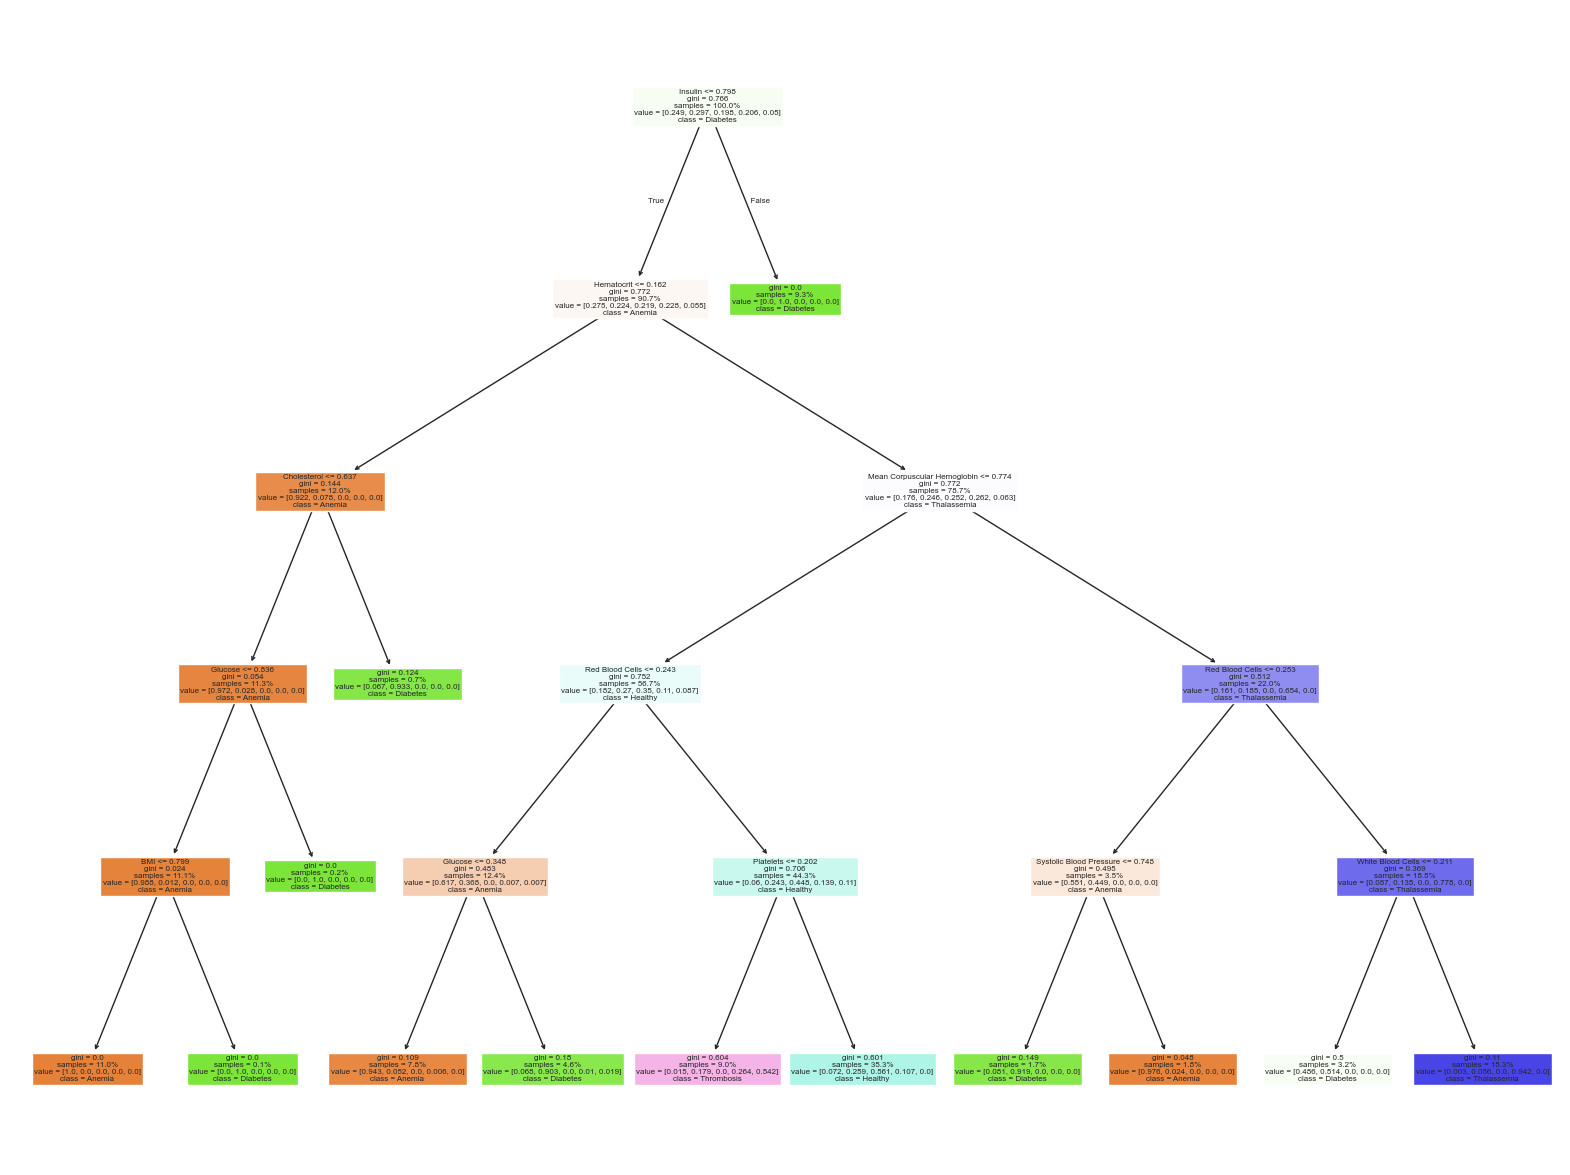

In [100]:
# Ajustar el mejor modelo con todo el conjunto de entrenamiento
arbol1.fit(X_train, y_train)
plt.figure(figsize=(20, 15))
plot_tree(arbol1, feature_names=X_train.columns.tolist(), filled=True,
         proportion = True, class_names=arbol1.classes_.tolist())
plt.show()

# XGBoost

In [101]:
xgb_classifier = XGBClassifier(booster = 'gbtree', n_estimators = 200, 
                               eta = 0.1, gamma = 1, random_state=seed, max_depth = 15, tree_method = 'hist')
xgb_classifier.fit(X_train, y_train_encoded)
y_pred_base = xgb_classifier.predict(X_test)

Veamos cual es la accuracy en train y en test:

In [102]:
y_train_pred = xgb_classifier.predict(X_train)
y_test_pred = xgb_classifier.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_encoded,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_encoded,y_test_pred)}')

Se tiene un accuracy para train de: 0.9995531724754245
Se tiene un accuracy para test de: 0.9678571428571429


## Fine tunning

In [104]:
params = {
    'n_estimators': [100,200,300],
    'eta' : [0.1,0.4,0.7],
    'gamma' : [0.1,0.5,1],
    'max_depth': [10, 15]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
#recordar que arbol2 es el árbol cuyas VI son todas las variables.
# cv = crossvalidation
grid_search_XGB = GridSearchCV(estimator=xgb_classifier, 
                           param_grid=params, 
                           cv=3, scoring = scoring_metrics, refit='accuracy')
grid_search_XGB.fit(X_train, y_train_encoded)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eta=0.1,
                                     eval_metric=None, feature_types=None,
                                     gamma=1, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_r...
                                     max_delta_step=None, max_depth=15,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=200,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'eta': [0.1, 0.4, 0.7], 'gamma': [0.1, 0.5, 1],
                         'max_depth': [10, 15],
                         'n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

## Evaluacion

In [105]:
modelo_XGB = grid_search_XGB.best_estimator_

y_train_pred_xgb = modelo_XGB.predict(X_train)
y_test_pred_xgb = modelo_XGB.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train_encoded,y_train_pred_xgb)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test_encoded,y_test_pred_xgb)}')

Se tiene un accuracy para train de: 1.0
Se tiene un accuracy para test de: 0.9732142857142857


In [106]:
cv_scores = cross_val_score(modelo_XGB, X_train, y_train_encoded, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.97050938 0.95710456 0.95442359]
Accuracy media de la validación cruzada: 0.961
Desviación estándar de las diferentes accuracys de la CV: 0.007


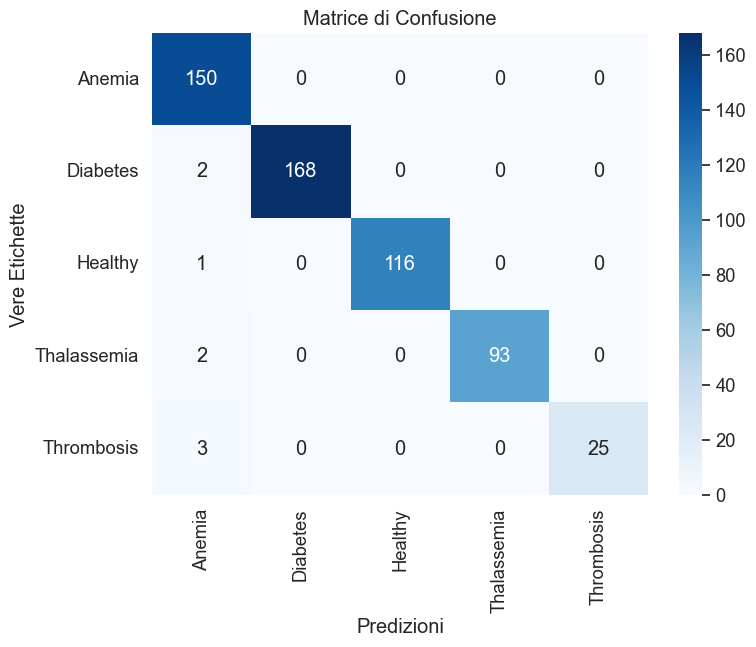

In [108]:
# Converti le etichette da one-hot encoding a etichette numeriche
y_test_classes = np.argmax(y_test_encoded, axis=1)
y_pred_classes = np.argmax(y_test_pred_xgb, axis=1)

# Calcola la matrice di confusione
cm = confusion_matrix(y_test_classes, y_pred_classes)
class_names = encoder.categories_[0]

# Visualizzare la matrice di confusione usando heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predizioni')
plt.ylabel('Vere Etichette')
plt.title('Matrice di Confusione')
plt.show()

In [116]:
# Ottenere i nomi delle classi
class_names = encoder.categories_[0]

# Convertire i numeri predetti in nomi di classi
y_test_actual = np.argmax(y_test_encoded, axis=1)
y_test_actual_names = [class_names[i] for i in y_test_actual]

y_test_predicted = np.argmax(y_test_pred_xgb, axis=1)
y_test_predicted_names = [class_names[i] for i in y_test_predicted]

# Identificare gli indici degli errori
error_indices = (y_test_actual != y_test_predicted)

# Creare un DataFrame con i risultati errati
df_errors = pd.DataFrame({
    'Indice': X_test.index[error_indices],
    'Predizione Attesa': [class_names[i] for i in y_test_actual[error_indices]],
    'Predizione Effettiva': [class_names[i] for i in y_test_predicted[error_indices]]
})

# Aggiungere le variabili predittive per un'analisi più dettagliata
df_errors = pd.concat([df_errors.reset_index(drop=True), 
                       X_test[error_indices].reset_index(drop=True)], axis=1)
df_errors[['Indice','White Blood Cells', 'Red Blood Cells', 'Hematocrit', 'Predizione Attesa','Predizione Effettiva']]

,Indice,White Blood Cells,Red Blood Cells,Hematocrit,Predizione Attesa,Predizione Effettiva
0,2738,0.405680,0.328027,0.561552,Healthy,Anemia
1,2414,0.749872,0.375216,0.770726,Thrombosis,Anemia
2,2731,0.989058,0.483537,0.926962,Thrombosis,Anemia
3,2708,0.785230,0.768724,0.622651,Thalassemia,Anemia
4,2766,0.304409,0.466161,0.053087,Diabetes,Anemia
5,2553,0.826346,0.883065,0.256472,Thalassemia,Anemia
6,2402,0.366764,0.698967,0.029899,Diabetes,Anemia
7,2806,0.526411,0.617095,0.982223,Thrombosis,Anemia


Il modello per questi valori predice anemia, perche' (ad eccezione per il numero 2708 e il 2806) presentano almeno un valore relativo al sangue basso rispetto a quello atteso, come si puo' notare dai boxplot fatti durante l'esplorazione.

- casi evidenti sono il 2766 e il 2402 che hanno valori di ematocrito inferiori a 0.1 ma e' dovuto al diabete. Ma come si puo' notare dal boxplot diseases ematocrito, sono evidenti eccezioni dato che in tutti gli alyti casi un valore di ematocrito inferiore a 0.15 indica anemia.

# Aggiungere conlusione su come il xgboost sia il modello migliore

# Saving best model

In [ ]:
# Salvare il modello migliore
model_save_path = os.path.join(MODELS_LOCATION, "disease_classification.joblib")
dump(modelo_XGB, model_save_path)
print(f"Modello salvato con successo in {model_save_path}")

In [120]:
# Caricare il modello salvato
best_xgb_model = load(model_save_path)
cv_scores = cross_val_score(best_xgb_model, X_train, y_train_encoded, cv=3)  

print("Accuracy de la validación cruzada: ", cv_scores)
print("Accuracy media de la validación cruzada: %.3f" % np.mean(cv_scores))
print("Desviación estándar de las diferentes accuracys de la CV: %.3f" % np.std(cv_scores))

Accuracy de la validación cruzada:  [0.97050938 0.95710456 0.95442359]
Accuracy media de la validación cruzada: 0.961
Desviación estándar de las diferentes accuracys de la CV: 0.007


In [121]:
class_names

array(['Anemia', 'Diabetes', 'Healthy', 'Thalassemia', 'Thrombosis'],
      dtype=object)